# Day 2: 4th order solvers vs. 2nd order

Let's import our usual things:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# unit conversions
MassOfSun = 2e33 # g
MassOfJupiter = 1.898e30 # g
AUinCM = 1.496e13 # cm
kmincm = 1e5 # cm/km
G = 6.674e-8 # gravitational constant in cm^3 g^-1 s^-2

Let's also use the same parameter's we've used before:

In [2]:
# in solar masses
M1 = 0.0009 # Jupiter
M2 = 1.0

# initial parameters
rp = 1.0 # in AU 
vp = 35.0 # in km/s

# conversions
M1 = M1*MassOfSun
M2 = M2*MassOfSun
vp = vp*kmincm
rp = rp*AUinCM

We'll include the acceleration calculator, and the energy and momentum calculators:

In [3]:
# Euler's method 2D calculations
def calcAcc(mj, ri, rj):
    mag_r = np.sqrt( (ri[0]-rj[0])**2 \
                    +(ri[1]-rj[1])**2 )
    mag_a = -G*mj/mag_r**2
    # unit vector points from particle 1 -> particle 2
    unitVector = (ri - rj)/mag_r
    # return
    return mag_a*unitVector

# energy
def calcE(m1, m2, r1, r2, v1, v2):
    mag_r = np.sqrt( (r1-r2).dot(r1-r2) )
    return 0.5*(m1*v1.dot(v1) + m2*v2.dot(v2)) - G*m1*m2/mag_r

# angular momentum
def calcL(m1, m2, r1, r2, v1, v2):
    #print(r1, v1, np.cross(r1,v1))
    L = m1*np.cross(r1,v1) + m2*np.cross(r2,v2)
    #mag_L = np.sqrt( L.dot(L) )
    # for 2D
    mag_L = np.sqrt(L*L)
    return mag_L


Format the initial conditions:

In [4]:
# initial conditions - in 2D
r_0 = np.array([[rp, 0], [0, 0]])
v_0 = np.array([[0, vp], [0, 0]])

Let's automatically calculate how many steps we wanna use:

In [5]:
# let's try to estimate how many steps we might need

# we can estimate a ~ initial distance 
a = np.sqrt( ((r_0[0,:]-r_0[1,:])**2).sum() )

Porb = np.sqrt( 4.0*np.pi**2.0*a**3.0/(G*(M1+M2)) )
delta_t = Porb*0.0001

n_steps = int(np.round(Porb/delta_t))*10

Do the calculation:

In [6]:
# Do the Euler's calculation

ri = r_0
vi = v_0

# initial value
r = [r_0]
E = [calcE(M1,M2, ri[0,:], ri[1,:], vi[0,:],vi[1,:])]
L = [calcL(M1,M2, ri[0,:], ri[1,:], vi[0,:],vi[1,:])]
t = [0] # time = 0

for i in range(n_steps):
    # use function to grab ag on particle 1
    ag1 = calcAcc(M2, ri[0,:], ri[1,:])
    ag2 = calcAcc(M1, ri[1,:], ri[0,:])
    
    # for ease, let's create a acceleration vector
    ag = np.array([ag1, ag2])
    
    # update new position and velocity
    ri1 = ri + vi*delta_t
    vi1 = vi + ag*delta_t
    
    # append to r vector
    r.append(ri1)
    
    # add E, L, t
    t.append(t[-1]+delta_t)
    newE = calcE(M1,M2, ri[0,:], ri[1,:], vi[0,:],vi[1,:])
    newL = calcL(M1,M2, ri[0,:], ri[1,:], vi[0,:],vi[1,:])
    E.append(newE)
    L.append(newL)
    
    # replace stuff
    ri = ri1
    vi = vi1



Format our outputs for plotting:

In [7]:
# format outputs

# r to array
r = np.array(r)
# in percentages
startE = E[0]; startL = L[0]
E = (E - E[0])/startE
L = (L - L[0])/startL
t = np.array(t)/(365*24*60*60.) # into years


Now let's plot just to remind ourselves what we are doing:

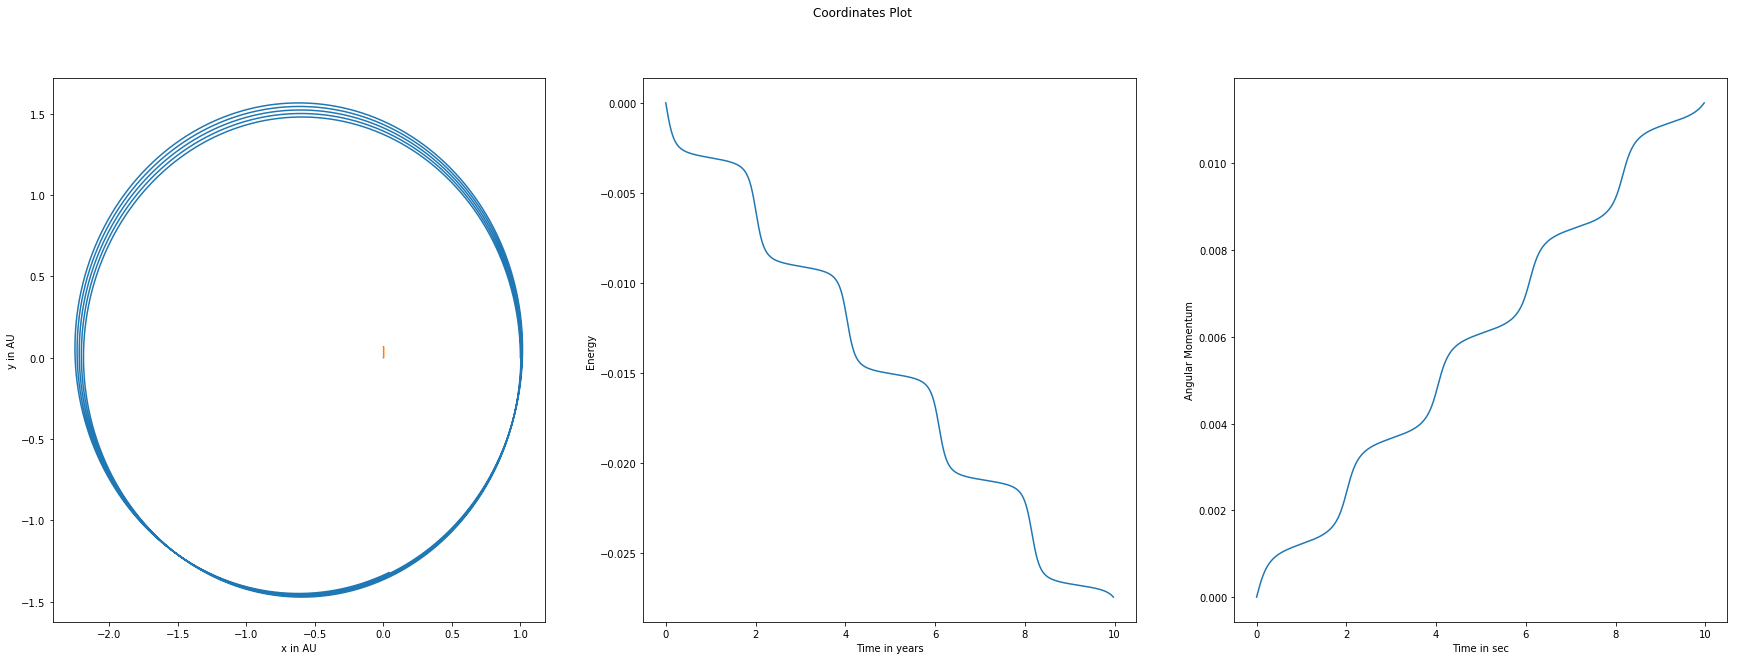

In [8]:
# let's plot!
fig, ax = plt.subplots(1, 3, figsize = (10*3, 10))
fig.suptitle('Coordinates Plot')

ax[0].set_xlabel('x in AU')
ax[0].set_ylabel('y in AU')

# plot Euler's solution, particle 1
ax[0].plot(r[:,0,0]/AUinCM, r[:,0,1]/AUinCM)

# particle 2
ax[0].plot(r[:,1,0]/AUinCM, r[:,1,1]/AUinCM)

ax[1].plot(t, E)
ax[1].set_xlabel('Time in years')
ax[1].set_ylabel('Energy')

ax[2].plot(t, L)
ax[2].set_xlabel('Time in sec')
ax[2].set_ylabel('Angular Momentum')

plt.show()

## Hermite solver - 4th order
To save ourselves some typing we'll import this as a library - download and store this in the directory were we are running our notebook from.

Save ```hermite_library.py``` in your running directory.

In [9]:
from hermite_library import do_hermite

In [10]:
star_mass = 1.0 # stellar mass in Msun
planet_masses = np.array( [1.0] ) # planet masses in Mjupiter

#vp = vp*kmincm
#rp = rp*AUinCM

# [x,y,z] coords for each planet in AU
# NOTE: no z-coords!  These will be set to zero later on if you make them non-zero
planet_initial_position = np.array([ [rp/AUinCM, 0.0, 0.0] ])

# planet's velocity at each position in km/s
# NOTE: no z-velocities!  These will be set to zero later on if you make them non-zero
planet_initial_velocity = np.array([ [0.0, vp/kmincm, 0.0] ])

# note: this assumes that the star is at (0, 0, 0) and has zero initial velocity


In [ ]:
# calculate!

# h is for hermite!
r_h, v_h, t_h, e_h = do_hermite(star_mass, 
                                planet_masses, 
                                planet_initial_position, 
                                planet_initial_velocity, 
                               tfinal=200, Nsteps=8800)
# note: tfinal is in N-body units, we won't go into this in detail
#  but there 
#     t_h = time*(l*AUinCM)/np.sqrt(G*masses.sum()/(l*AUinCM)) # units of time


t_h = t_h/(365.*24*60*60)
e_h = (e_h-e_h[0])/e_h[0]

$t_h$ is physical, $t$ is N-body:
$t_h = t \times \frac{( \langle r \rangle \times AUinCM )^{1/2}}{G \Sigma_i M_i}$

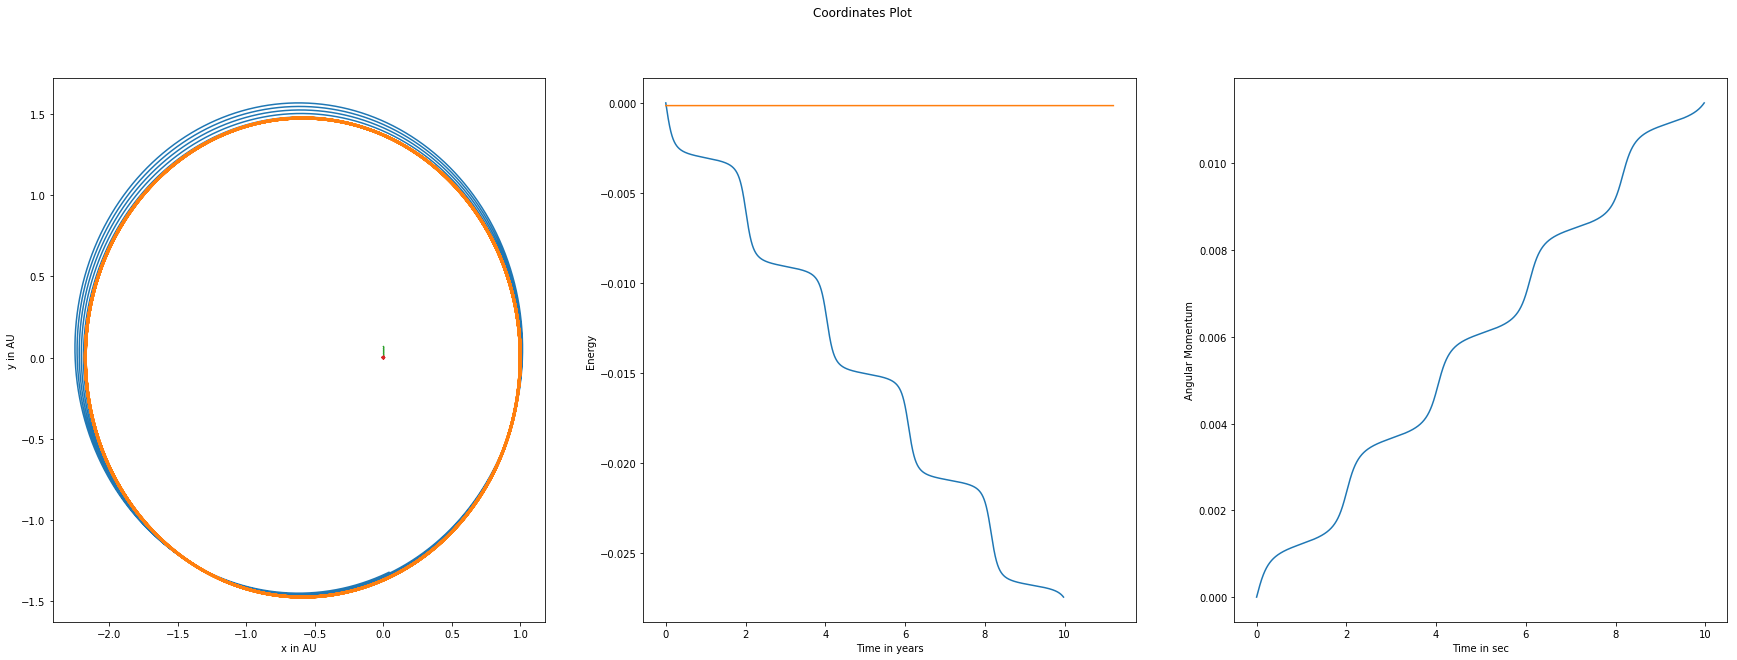

In [30]:
# let's plot!
fig, ax = plt.subplots(1, 3, figsize = (10*3, 10))
fig.suptitle('Coordinates Plot')

ax[0].set_xlabel('x in AU')
ax[0].set_ylabel('y in AU')

# plot Euler's solution, particle 1
ax[0].plot(r[:,0,0]/AUinCM, r[:,0,1]/AUinCM)
ax[0].plot(r_h[0,0,:], r_h[0,1,:], lw=3)

# particle 2
ax[0].plot(r[:,1,0]/AUinCM, r[:,1,1]/AUinCM)
ax[0].plot(r_h[1,0,:], r_h[1,1,:], lw=3)

ax[1].plot(t, E)
ax[1].set_xlabel('Time in years')
ax[1].set_ylabel('Energy')
# re-norm energy
ax[1].plot(t_h, e_h)

ax[2].plot(t, L)
ax[2].set_xlabel('Time in sec')
ax[2].set_ylabel('Angular Momentum')

plt.show()

So we can see that over the same time period the energy doesn't change!

### Exercise
Try this comparison with other masses.

Bonus: add in an angular momentum calculation to the library and plot this as an analysis plot